In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
import pathlib
import joblib
from lb2jpsil import lorentz

In [2]:
## Self explanatory
save_plots = True

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = False

## Toggle plot grid
show_grid = True

## Black and white?
black_and_white = True

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

## Select signal region ([5508.5, 5731.8] MeV/c^2)
only_sig_region = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.714
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.637
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'shamshel'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    hard_threshold = saved_models[model_to_use]['hard_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    hard_threshold = 0.9
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.003_100_2500_BAL'

In [8]:
## Create plots directory, if missing
repo_directory = str(pathlib.Path.home()) + '/lambda-emdm-measurement/'
state_directory = str(pathlib.Path.home()) + '/classifier-studies/' + '20_HBDT/' + 'saved_states/'

plot_directory = (
    repo_directory + 'plots/'
    + 'proton_angle_resolutions/'
)

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Data prepping
## Import Monte Carlo data

In [10]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [11]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

#del(df_reco, df_truth)
del(df_reco)

In [12]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [13]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [14]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

#df_mc[pre_selection_cuts]

## Add derived variables

In [15]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [16]:
add_derived_variables(df_mc)

## Drop events not passing the prefilter

In [17]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)

## Score HBDT and keep events above hard threshold

In [18]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [19]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [20]:
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
df_mc['HBDT'] = mc_predicted
mc_pass_threshold = df_mc['HBDT'] > hard_threshold

In [21]:
df_mc.drop(df_mc[~mc_pass_threshold].index, inplace=True)

del(mc_predicted)

One last thing: excise events outside of the desired invariant mass window.

In [22]:
if only_sig_region:
    lower_limit_mass = 5496.2
    upper_limit_mass = 5744
else:
    lower_limit_mass = 5000
    upper_limit_mass = 6200

mc_Lb_invmass_cut = ((df_mc['DTF_FixJPsiLambda_Lb_M'] > lower_limit_mass) & (df_mc['DTF_FixJPsiLambda_Lb_M'] < upper_limit_mass))

In [23]:
df_mc.drop(df_mc[~mc_Lb_invmass_cut].index, inplace=True)

In [24]:
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.993490
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,T,619,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.995001
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,T,798,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.988892
56,1.0630,-0.1569,14.631200,-16.393600,-267.315704,7429.070312,19.139999,-1164.579956,32903.449219,-108.959999,...,T,1391,1677.147461,1222.470947,1180.346313,260.234802,254.823410,243.301285,2582.130859,0.986191
71,1.8416,-1.3280,21.833700,628.105896,-929.930481,7475.404785,3879.139893,-5898.799805,47200.421875,1059.250000,...,T,1897,5397.982422,6764.600098,6947.719238,1786.030396,1679.542480,1734.952637,6626.127441,0.997901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366267,1.4960,0.4462,-21.932100,171.948593,299.047791,7071.188477,1051.619995,1886.640015,46525.289062,303.820007,...,T,8918745,2245.093506,1952.591919,2039.183350,553.135132,510.911560,556.640259,4791.497559,0.993085
366268,0.9817,-0.2910,-13.832300,402.671509,16.624701,8214.584961,1634.530029,26.360001,33188.000000,113.620003,...,T,8918751,2154.688965,1975.448608,1626.364014,105.307137,119.006645,118.100471,2818.800293,0.986714
366313,0.4253,-0.0151,-0.922200,-159.258698,-53.847301,5842.161133,-2971.840088,-964.760010,105195.726562,-334.529999,...,T,8919632,4219.451660,3628.397949,3111.473877,156.685303,316.524811,366.231476,3196.120117,0.996885


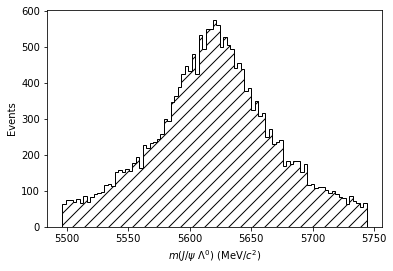

In [25]:
common_plot_params = {
    'bins': 87,
    'histtype': 'stepfilled',
    'facecolor': 'none',
    'edgecolor': 'black',
    'hatch': '//'
}

xlabel = "$m(J/\psi~\Lambda^0)$ (MeV/$c^2$)"
ylabel = 'Events'

plt.hist(df_mc['DTF_FixJPsiLambda_Lb_M'], **common_plot_params)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

# Compute proton helicity angles

In [26]:
def norm(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

In [27]:
def calculate_helicity_angle(
    df: pd.DataFrame,
    daughter: str,
    mother: str,
    daughter_suffix: str,
    mother_suffix: str,
    angle_suffix: str = None
):
    if angle_suffix is not None:
        angle_suffix = '_' + angle_suffix
    else:
        angle_suffix = ''
    
    daughter_p = np.array([
        df[f'{daughter}_PX_{daughter_suffix}'],
        df[f'{daughter}_PY_{daughter_suffix}'],
        df[f'{daughter}_PZ_{daughter_suffix}']])
    mother_p = np.array([
        df[f'{mother}_PX_{mother_suffix}'],
        df[f'{mother}_PY_{mother_suffix}'],
        df[f'{mother}_PZ_{mother_suffix}']])
    angle = lorentz.cos_angle(mother_p, daughter_p)
    df[f'{daughter}_Theta{angle_suffix}'] = angle

## What it does: computes momenta in Lambda frame and Lambdab frames
## Then computes angle between p(p) in Lambda frame and p(Lambda) in Lambdab frame 
def calculate_proton_lambda_helicity_angle(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_end='LambdaFrame')
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']
    calculate_helicity_angle(df, f'{prefix}p', f'{prefix}L',
                             daughter_suffix='LambdaFrame', mother_suffix='LambdabFrame')

## Same thing as above, but use LambdaFromLambdabFrame for the p frame. Instead of going lab->Lambda,
## we do lab->Lambdab->Lambda for the proton
def calculate_proton_lambda_helicity_angle_from_lambdab_frame(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')

    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']

    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_start='LambdabFrame', suffix_end='LambdaFromLambdabFrame')
        
    calculate_helicity_angle(
        df, f'{prefix}p', f'{prefix}L',
        daughter_suffix='LambdaFromLambdabFrame', mother_suffix='LambdabFrame', angle_suffix='IFM')

In [28]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [29]:
def cross_product(v1, v2):
    u0 = v1[1] * v2[2] - v1[2] * v2[1]
    u1 = v1[2] * v2[0] - v1[0] * v2[2]
    u2 = v1[0] * v2[1] - v1[1] * v2[0]
    
    return np.array([u0, u1, u2])

In [30]:
def calculate_at_rest_kine(
    df: pd.DataFrame,
    daughters: dict,
    suffix_start: str = None,
    suffix_end: str = 'Star'
):
    
    if suffix_start is not None:
        suffix_start = '_' + suffix_start
    else:
        suffix_start = ''
    
    daughters_p = {
        part_name: lorentz.four_vector_from_PXPYPZM(
            df[f'{part_name}_PX{suffix_start}'],
            df[f'{part_name}_PY{suffix_start}'],
            df[f'{part_name}_PZ{suffix_start}'],
            part_mass)
        for part_name, part_mass in daughters.items()
    }
    
    mother_p = sum(daughters_p.values())
    daughters_p_star = {
        part_name: lorentz.boost_from_mom(part_p, mother_p)
        for part_name, part_p in daughters_p.items()
    }
    
    for part_name, p_star in daughters_p_star.items():
        df[f'{part_name}_PX_{suffix_end}'] = p_star[0]
        df[f'{part_name}_PY_{suffix_end}'] = p_star[1]
        df[f'{part_name}_PZ_{suffix_end}'] = p_star[2]
        df[f'{part_name}_P_{suffix_end}'] = np.sqrt(p_star[0]**2 + p_star[1]**2 + p_star[2]**2)

In [31]:
def calculate_proton_lambda_angular_distribution(df, prefix):
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
        f'{prefix}mup' : 105.6583755,
        f'{prefix}mum' : 105.6583755,
    }, suffix_end='LambdabFrame')
    
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}L_P{coord}_LambdabFrame'] = df[f'{prefix}p_P{coord}_LambdabFrame'] + df[f'{prefix}pim_P{coord}_LambdabFrame']
    
    calculate_at_rest_kine(df, {
        f'{prefix}p' : 938.27208816,
        f'{prefix}pim' : 139.57018,
    }, suffix_start='LambdabFrame', suffix_end='LambdaFromLambdabFrame')
    

    Lambda_p_in_Lambdab_frame = np.array([
        df[f'{prefix}L_PX_LambdabFrame'],
        df[f'{prefix}L_PY_LambdabFrame'],
        df[f'{prefix}L_PZ_LambdabFrame']
    ])
    
    Lambda_p_in_Lambdab_frame_hat = lorentz.unit_vector(Lambda_p_in_Lambdab_frame)
    
    for coord in ['X', 'Y', 'Z']:
        df[f'{prefix}Lb_P{coord}'] = (
            df[f'{prefix}p_P{coord}']
            + df[f'{prefix}pim_P{coord}']
            + df[f'{prefix}mum_P{coord}']
            + df[f'{prefix}mup_P{coord}']
        )
    
    z0_in_Lambdab_frame = lorentz.unit_vector(np.array([df[f'{prefix}Lb_P{coord}'] for coord in ['X', 'Y', 'Z']]))
    z0_in_Lambdab_frame_parallel = scalar_product(z0_in_Lambdab_frame, Lambda_p_in_Lambdab_frame_hat)
    
    b_z0PerpLambda = z0_in_Lambdab_frame - z0_in_Lambdab_frame_parallel * Lambda_p_in_Lambdab_frame_hat
    x2_in_Lambdab_frame = - b_z0PerpLambda / norm(b_z0PerpLambda)
    
    x0_in_Lambda_frame = x2_in_Lambdab_frame
    z0_in_Lambda_frame = Lambda_p_in_Lambdab_frame_hat
    y0_in_Lambda_frame = cross_product(z0_in_Lambda_frame, x0_in_Lambda_frame)
    
    proton_p_IFM = np.array([
        df[f'{prefix}p_PX_LambdaFromLambdabFrame'],
        df[f'{prefix}p_PY_LambdaFromLambdabFrame'],
        df[f'{prefix}p_PZ_LambdaFromLambdabFrame']])
    
    proton_p_IFM_hat = lorentz.unit_vector(proton_p_IFM)
    
    proton_y_projection = scalar_product(proton_p_IFM_hat, y0_in_Lambda_frame)
    proton_x_projection = scalar_product(proton_p_IFM_hat, x0_in_Lambda_frame)
    
    theta = scalar_product(proton_p_IFM_hat, z0_in_Lambda_frame)
    phi = np.arctan2(proton_y_projection, proton_x_projection)
    
    df[f'{prefix}p_Phi'] = phi
    df[f'{prefix}p_CosTheta'] = theta

In [32]:
calculate_proton_lambda_angular_distribution(df_truth, 'MCTRUTH_')

In [33]:
calculate_proton_lambda_angular_distribution(df_mc, 'MCTRUTH_')
calculate_proton_lambda_angular_distribution(df_mc, 'DTF_FixJPsiLambda_')

# Proton $\theta$ angle resolution

## Migration matrix

In [34]:
theta_edges = np.linspace(-1,1,9)
theta_bins = [(l,r) for l, r in zip(theta_edges[:-1], theta_edges[1:])] 

In [35]:
theta_migration_matrix = []

for bin_true in theta_bins:
    bin_true_selection = (
        (df_mc['MCTRUTH_p_CosTheta'] >= bin_true[0])
        & (df_mc['MCTRUTH_p_CosTheta'] < bin_true[1])
    )
    events_in_bin_true = sum(bin_true_selection)
    row = []
    for bin_reco in theta_bins:
        bin_reco_selection = (
            bin_true_selection
            & (df_mc['DTF_FixJPsiLambda_p_CosTheta'] >= bin_reco[0])
            & (df_mc['DTF_FixJPsiLambda_p_CosTheta'] < bin_reco[1])
        )
        events_in_bin_reco_and_bin_true = sum(bin_reco_selection)
        row.append(events_in_bin_reco_and_bin_true/events_in_bin_true)
        
    theta_migration_matrix.insert(0, row)
    
theta_migration_matrix = np.array(theta_migration_matrix)

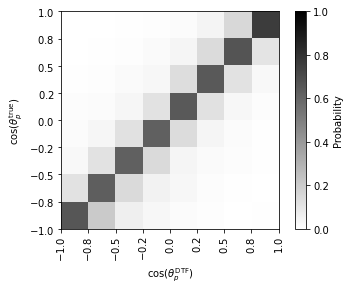

In [58]:
fig, ax = plt.subplots()

plt.imshow(theta_migration_matrix, cmap='binary', vmin=0, vmax=1)

plt.colorbar(label='Probability')
ax.xaxis.set(ticks=np.arange(-0.5, len(theta_edges)-1), ticklabels=[f'${"{:.1f}".format(i)}$' for i in theta_edges])
ax.yaxis.set(ticks=np.arange(-0.5, len(theta_edges)-1), ticklabels=[f'${"{:.1f}".format(i)}$' for i in theta_edges[::-1]])
plt.xlabel(r'$\cos(\theta_p^\mathrm{DTF})$')
plt.ylabel(r'$\cos(\theta_p^\mathrm{true})$')
plt.xticks(rotation=90)

if show_titles:
    plt.title(r"Proton $\theta$ helicity angle migration matrix" + "\n" + "(MC simulation, reco sample)")

if save_plots:
    plt.savefig(plot_directory + 'MCRECO_p_theta_migration' + '.pdf', bbox_inches = 'tight')

plt.show()

## Resolution

In [37]:
df_mc['CosTheta_Residual'] = df_mc['DTF_FixJPsiLambda_p_CosTheta'] - df_mc['MCTRUTH_p_CosTheta']

df_res_theta = pd.DataFrame(columns=[
    'theta_mean', 'theta_error',
    'resolution_mean', 'resolution_error',
    'resolution_rel_mean', 'resolution_rel_error'
])

for bin_true in theta_bins:
    bin_true_selection = (
        (df_mc['MCTRUTH_p_CosTheta'] >= bin_true[0])
        & (df_mc['MCTRUTH_p_CosTheta'] < bin_true[1])
    )
    
    resolution_dict = {}
    
    resolution_dict['theta_mean'] = np.mean(df_mc.loc[bin_true_selection, 'MCTRUTH_p_CosTheta'])
    resolution_dict['theta_error'] = np.std(df_mc.loc[bin_true_selection, 'MCTRUTH_p_CosTheta'])
    
    squared_mean_resolution = np.mean(df_mc.loc[bin_true_selection, 'CosTheta_Residual']**2)
    squared_mean_resolution_error = ss.sem(df_mc.loc[bin_true_selection, 'CosTheta_Residual']**2)
    
    resolution_dict['resolution_mean'] = np.sqrt(squared_mean_resolution)
    resolution_dict['resolution_error'] = .5 * squared_mean_resolution_error / resolution_dict['resolution_mean']
    resolution_dict['resolution_rel_mean'] = resolution_dict['resolution_mean'] / np.abs(resolution_dict['theta_mean'])
    resolution_dict['resolution_rel_error'] = resolution_dict['resolution_error'] / np.abs(resolution_dict['theta_mean'])
    
    df_res_theta = df_res_theta.append(resolution_dict, ignore_index=True)
    
df_res_theta

,theta_mean,theta_error,resolution_mean,resolution_error,resolution_rel_mean,resolution_rel_error
0,-0.867817,0.071327,0.306080,0.011437,0.352701,0.013179
1,-0.622864,0.072084,0.272707,0.008564,0.437828,0.013750
2,-0.371023,0.072152,0.254988,0.006769,0.687257,0.018243
3,-0.124299,0.071394,0.233960,0.005531,1.882237,0.044496
4,0.121198,0.072412,0.234111,0.005899,1.931639,0.048671
5,0.371464,0.071855,0.241613,0.007108,0.650436,0.019135
6,0.619283,0.071317,0.230048,0.008758,0.371474,0.014142
7,0.874137,0.072243,0.246876,0.012169,0.282423,0.013922


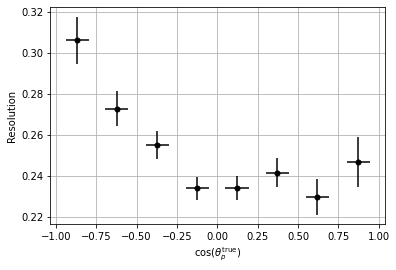

In [38]:
plt.errorbar(
    x=df_res_theta['theta_mean'],
    y=df_res_theta['resolution_mean'],
    xerr=df_res_theta['theta_error'],
    yerr=df_res_theta['resolution_error'],
    color='black',
    linestyle='',
    marker='.',
    markersize=10
)

plt.xlabel(r'$\cos(\theta_p^{\mathrm{true}})$')
plt.ylabel("Resolution")

if show_grid:
    plt.grid()

if show_titles:
    plt.title(r"Proton $\theta$ helicity angle resolution" + "\n" + "(MC simulation, reco sample)")

if save_plots:
    plt.savefig(plot_directory + 'MCRECO_p_theta_resolution' + '.pdf', bbox_inches = 'tight')

plt.show()

## $\theta$ resolution vs. variables

In [39]:
def theta_resolution_vs_variable_dataframe(
    df: pd.DataFrame,
    var_short_name: str,
    var_series: pd.Series,
    bin_left: float,
    bin_right: float,
    n_bins: int,
) -> pd.DataFrame:
    
    edges = np.linspace(bin_left, bin_right, n_bins+1)
    bins = [(l,r) for l, r in zip(edges[:-1], edges[1:])] 
    
    df_res = pd.DataFrame(columns = [
        'theta_mean', 'theta_error', 'resolution_mean', 'resolution_error',
        'resolution_rel_mean', 'resolution_rel_error',
        f'{var_short_name}_mean', f'{var_short_name}_error', 
    ])
    
    for bin_true in bins:
        bin_true_selection = (
            (var_series >= bin_true[0])
            & (var_series < bin_true[1])
        )

        resolution_dict = {}

        resolution_dict['theta_mean'] = np.mean(df.loc[bin_true_selection, 'MCTRUTH_p_CosTheta'])
        resolution_dict['theta_error'] = np.std(df.loc[bin_true_selection, 'MCTRUTH_p_CosTheta'])

        resolution_dict[f'{var_short_name}_mean'] = np.mean(var_series.loc[bin_true_selection])
        resolution_dict[f'{var_short_name}_error'] = np.std(var_series.loc[bin_true_selection])

        squared_mean_resolution = np.mean(df.loc[bin_true_selection, 'CosTheta_Residual']**2)
        squared_mean_resolution_error = ss.sem(df.loc[bin_true_selection, 'CosTheta_Residual']**2)

        resolution_dict['resolution_mean'] = np.sqrt(squared_mean_resolution)
        resolution_dict['resolution_error'] = .5 * squared_mean_resolution_error / resolution_dict['resolution_mean']
        resolution_dict['resolution_rel_mean'] = resolution_dict['resolution_mean'] / np.abs(resolution_dict['theta_mean'])
        resolution_dict['resolution_rel_error'] = resolution_dict['resolution_error'] / np.abs(resolution_dict['theta_mean'])

        df_res = df_res.append(resolution_dict, ignore_index=True)
        
    return df_res

In [40]:
def theta_resolution_vs_variable_plots(
    df_resolution: pd.DataFrame,
    var_short_name: str,
    var_label: str,
    var_title: str,
) -> None:
    
    ## FIRST PLOT: resolution vs. variable
    plt.errorbar(
        x=df_resolution[f'{var_short_name}_mean'],
        y=df_resolution['resolution_mean'],
        xerr=df_resolution[f'{var_short_name}_error'],
        yerr=df_resolution['resolution_error'],
        color='black',
        linestyle='',
        marker='.',
        markersize=10
    )

    plt.xlabel(var_label)
    plt.ylabel(r"$\cos\theta_p$ resolution")

    if show_grid:
        plt.grid()    
    
    if show_titles:
        plt.title(fr"Proton $\theta$ resolution as function of {var_title}" + "\n" + "(MC simulation, reco sample)")

    if save_plots:
        plt.savefig(plot_directory + f'MCRECO_p_theta_resolution_vs_{var_short_name}' + '.pdf', bbox_inches = 'tight')

    plt.show()
    
    ## SECOND PLOT: theta mean value vs. variable
    plt.errorbar(
        x=df_resolution[f'{var_short_name}_mean'],
        y=df_resolution['theta_mean'],
        xerr=df_resolution[f'{var_short_name}_error'],
        yerr=df_resolution['theta_error'],
        color='black',
        linestyle='',
        marker='.',
        markersize=10
    )

    plt.xlabel(var_label)
    plt.ylabel(r'$\cos(\theta_p^{true})$')
    
    if show_grid:
        plt.grid()

    if show_titles:
        plt.title(fr"True $\theta$ vs. {var_title}" + "\n" + "(MC simulation, reco sample)")

    if save_plots:
        plt.savefig(plot_directory + f'MCRECO_p_theta_vs_{var_short_name}' + '.pdf', bbox_inches = 'tight')

    plt.show()

### Vs. proton $p_z$

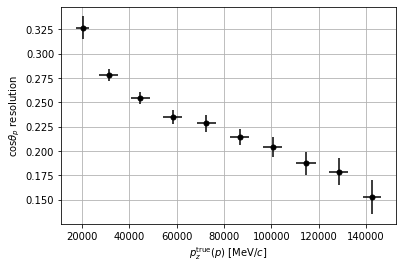

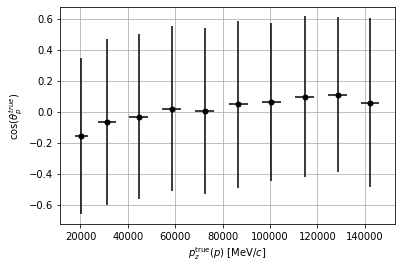

In [41]:
var_short_name = 'p_pz'
var_series = df_mc['MCTRUTH_p_PZ']
var_label = r'$p_z^\mathrm{true} (p)$ [MeV/$c$]'
var_title = "proton $p_z$"
bin_left = 1e4
bin_right = 15e4
n_bins = 10

df_res = theta_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

theta_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

### Vs. $\Lambda^0$ decay vertex

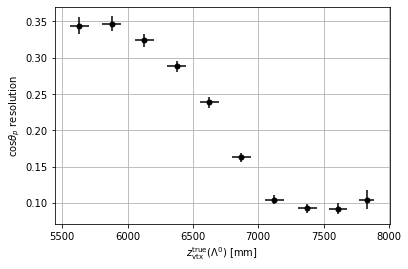

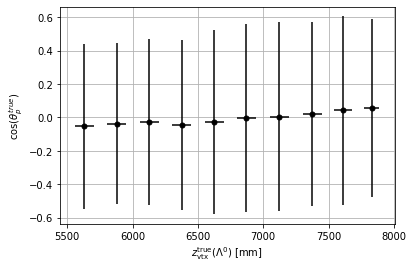

In [42]:
var_short_name = 'L_endvertex_z'
var_series = df_mc['MCTRUTH_L_ENDVERTEX_Z']
var_label = r'$z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]'
var_title = "$\Lambda^0$ $z$ vertex"
bin_left = 5500
bin_right = 8000
n_bins = 10

df_res = theta_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

theta_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

### Vs. $\Lambda^0$ decay vertex bias

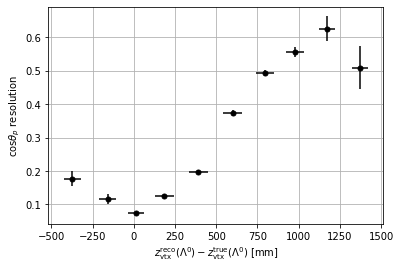

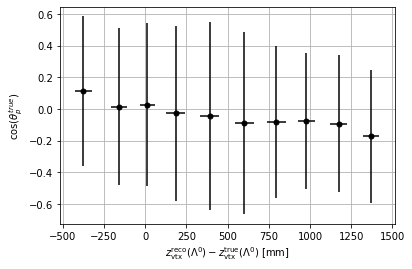

In [43]:
var_short_name = 'L_endvertex_z_bias'
var_series = df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']
var_label = r'$z_\mathrm{vtx}^\mathrm{reco} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]'
var_title = "$\Lambda^0$ $z$ vertex bias"
bin_left = -500
bin_right = 1500
n_bins = 10

df_res = theta_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

theta_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

### Vs. proto-particle positions

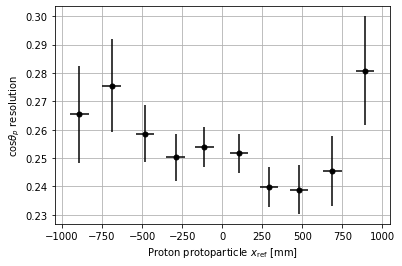

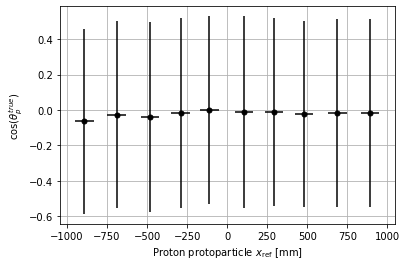

In [44]:
var_short_name = 'proton_PP_x'
var_series = df_mc['p_PP_X']
var_label = r'Proton protoparticle $x_\mathrm{ref}$ [mm]'
var_title = "proton proroparticle $x$ refpoint"
bin_left = -1000
bin_right = 1000
n_bins = 10

df_res = theta_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

theta_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

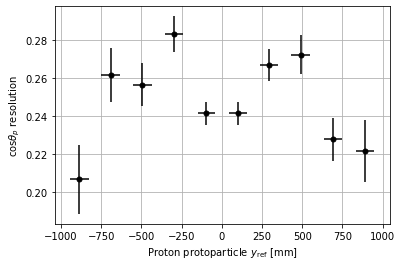

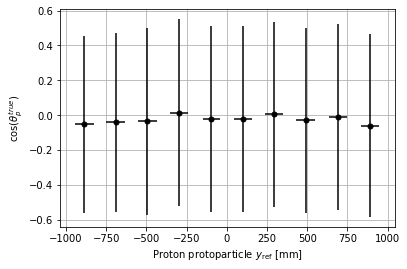

In [45]:
var_short_name = 'proton_PP_y'
var_series = df_mc['p_PP_Y']
var_label = r'Proton protoparticle $y_\mathrm{ref}$ [mm]'
var_title = "proton proroparticle $y$ refpoint"
bin_left = -1000
bin_right = 1000
n_bins = 10

df_res = theta_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

theta_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

# Proton $\phi$ angle resolution

## Migration matrix

In [46]:
phi_edges = np.linspace(-np.pi,np.pi,13)
phi_bins = [(l,r) for l, r in zip(phi_edges[:-1], phi_edges[1:])] 

In [47]:
phi_migration_matrix = []

for bin_true in phi_bins:
    bin_true_selection = (
        (df_mc['MCTRUTH_p_Phi'] >= bin_true[0])
        & (df_mc['MCTRUTH_p_Phi'] < bin_true[1])
    )
    events_in_bin_true = sum(bin_true_selection)
    row = []
    for bin_reco in phi_bins:
        bin_reco_selection = (
            bin_true_selection
            & (df_mc['DTF_FixJPsiLambda_p_Phi'] >= bin_reco[0])
            & (df_mc['DTF_FixJPsiLambda_p_Phi'] < bin_reco[1])
        )
        events_in_bin_reco_and_bin_true = sum(bin_reco_selection)
        row.append(events_in_bin_reco_and_bin_true/events_in_bin_true)
        
    phi_migration_matrix.insert(0, row)
    
phi_migration_matrix = np.array(phi_migration_matrix)

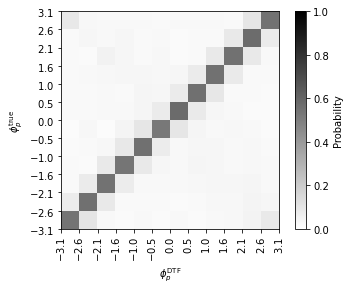

In [48]:
fig, ax = plt.subplots()

plt.imshow(phi_migration_matrix, cmap='binary', vmin=0, vmax=1)

plt.colorbar(label='Probability')
ax.xaxis.set(ticks=np.arange(-0.5, len(phi_edges)-1), ticklabels=[f'${"{:.1f}".format(i)}$' for i in phi_edges])
ax.yaxis.set(ticks=np.arange(-0.5, len(phi_edges)-1), ticklabels=[f'${"{:.1f}".format(i)}$' for i in phi_edges[::-1]])
plt.xlabel(r'$\phi_p^\mathrm{DTF}$')
plt.ylabel(r'$\phi_p^\mathrm{true}$')
plt.xticks(rotation=90)
if show_titles:
    plt.title(r"Proton $\phi$ helicity angle migration matrix" + "\n" + "(MC simulation, reco sample)")

if save_plots:
    plt.savefig(plot_directory + 'MCRECO_p_phi_migration' + '.pdf', bbox_inches = 'tight')

plt.show()

## Resolution

In [49]:
## Assumes greater > lesser, i.e. greater - lesser > 0
def distance_between_angles(lesser, greater):
    distance_inside = abs(lesser - greater) % (2*np.pi)
    distance_outside = (abs(lesser + np.pi) + abs(np.pi - greater)) % (2*np.pi)
    
    return np.where(distance_inside < distance_outside, distance_inside, distance_outside)

In [50]:
df_mc['Phi_Residual'] = np.where(
    df_mc['DTF_FixJPsiLambda_p_Phi'] - df_mc['MCTRUTH_p_Phi'] < 0,
    distance_between_angles(df_mc['DTF_FixJPsiLambda_p_Phi'], df_mc['MCTRUTH_p_Phi']),
    distance_between_angles(df_mc['MCTRUTH_p_Phi'], df_mc['DTF_FixJPsiLambda_p_Phi'])
)


df_res_phi = pd.DataFrame(columns=[
    'phi_mean', 'phi_error',
    'resolution_mean', 'resolution_error',
    'resolution_rel_mean', 'resolution_rel_error'
])

for bin_true in phi_bins:
    bin_true_selection = (
        (df_mc['MCTRUTH_p_Phi'] >= bin_true[0])
        & (df_mc['MCTRUTH_p_Phi'] < bin_true[1])
    )
    
    resolution_dict = {}
    
    resolution_dict['phi_mean'] = np.mean(df_mc.loc[bin_true_selection, 'MCTRUTH_p_Phi'])
    resolution_dict['phi_error'] = np.std(df_mc.loc[bin_true_selection, 'MCTRUTH_p_Phi'])
    
    squared_mean_resolution = np.mean(df_mc.loc[bin_true_selection, 'Phi_Residual']**2)
    squared_mean_resolution_error = ss.sem(df_mc.loc[bin_true_selection, 'Phi_Residual']**2)
    
    resolution_dict['resolution_mean'] = np.sqrt(squared_mean_resolution)
    resolution_dict['resolution_error'] = .5 * squared_mean_resolution_error / resolution_dict['resolution_mean']
    resolution_dict['resolution_rel_mean'] = resolution_dict['resolution_mean'] / np.abs(resolution_dict['phi_mean'])
    resolution_dict['resolution_rel_error'] = resolution_dict['resolution_error'] / np.abs(resolution_dict['phi_mean'])
    
    df_res_phi = df_res_phi.append(resolution_dict, ignore_index=True)
    
df_res_phi

,phi_mean,phi_error,resolution_mean,resolution_error,resolution_rel_mean,resolution_rel_error
0,-2.879041,0.151357,1.035224,0.026050,0.359573,0.009048
1,-2.354122,0.153445,1.072109,0.025299,0.455418,0.010747
2,-1.833247,0.150101,1.164652,0.025497,0.635295,0.013908
3,-1.308910,0.149326,1.146819,0.025801,0.876163,0.019712
4,-0.787100,0.150769,1.086464,0.025764,1.380338,0.032733
5,-0.259432,0.150917,1.032080,0.025932,3.978228,0.099956
6,0.272883,0.150530,1.013603,0.026463,3.714419,0.096975
7,0.779686,0.152764,1.047661,0.025765,1.343696,0.033045
8,1.306853,0.149254,1.125584,0.025442,0.861294,0.019468
9,1.829227,0.152504,1.142297,0.026292,0.624470,0.014374


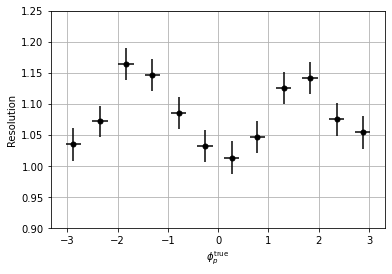

In [51]:
plt.errorbar(
    x=df_res_phi['phi_mean'],
    y=df_res_phi['resolution_mean'],
    xerr=df_res_phi['phi_error'],
    yerr=df_res_phi['resolution_error'],
    color='black',
    linestyle='',
    marker='.',
    markersize=10
)

plt.xlabel(r'$\phi_p^{\mathrm{true}}$')
plt.ylabel("Resolution")

if show_titles:
    plt.title(r"Proton $\phi$ helicity angle resolution" + "\n" + "(MC simulation, reco sample)")

if show_grid:
    plt.grid()
    
if save_plots:
    plt.savefig(plot_directory + 'MCRECO_p_phi_resolution' + '.pdf', bbox_inches = 'tight')

plt.ylim(0.9,1.25)
    
plt.show()

## $\phi$ resolution vs. variables

In [52]:
def phi_resolution_vs_variable_dataframe(
    df: pd.DataFrame,
    var_short_name: str,
    var_series: pd.Series,
    bin_left: float,
    bin_right: float,
    n_bins: int,
) -> pd.DataFrame:
    
    edges = np.linspace(bin_left, bin_right, n_bins+1)
    bins = [(l,r) for l, r in zip(edges[:-1], edges[1:])] 
    
    df_res = pd.DataFrame(columns = [
        'phi_mean', 'phi_error', 'resolution_mean', 'resolution_error',
        'resolution_rel_mean', 'resolution_rel_error',
        f'{var_short_name}_mean', f'{var_short_name}_error', 
    ])
    
    for bin_true in bins:
        bin_true_selection = (
            (var_series >= bin_true[0])
            & (var_series < bin_true[1])
        )

        resolution_dict = {}

        resolution_dict['phi_mean'] = np.mean(df.loc[bin_true_selection, 'MCTRUTH_p_Phi'])
        resolution_dict['phi_error'] = np.std(df.loc[bin_true_selection, 'MCTRUTH_p_Phi'])

        resolution_dict[f'{var_short_name}_mean'] = np.mean(var_series.loc[bin_true_selection])
        resolution_dict[f'{var_short_name}_error'] = np.std(var_series.loc[bin_true_selection])

        squared_mean_resolution = np.mean(df.loc[bin_true_selection, 'Phi_Residual']**2)
        squared_mean_resolution_error = ss.sem(df.loc[bin_true_selection, 'Phi_Residual']**2)

        resolution_dict['resolution_mean'] = np.sqrt(squared_mean_resolution)
        resolution_dict['resolution_error'] = .5 * squared_mean_resolution_error / resolution_dict['resolution_mean']
        resolution_dict['resolution_rel_mean'] = resolution_dict['resolution_mean'] / np.abs(resolution_dict['phi_mean'])
        resolution_dict['resolution_rel_error'] = resolution_dict['resolution_error'] / np.abs(resolution_dict['phi_mean'])

        df_res = df_res.append(resolution_dict, ignore_index=True)
        
    return df_res

In [53]:
def phi_resolution_vs_variable_plots(
    df_resolution: pd.DataFrame,
    var_short_name: str,
    var_label: str,
    var_title: str,
) -> None:
    
    ## FIRST PLOT: resolution vs. variable
    plt.errorbar(
        x=df_resolution[f'{var_short_name}_mean'],
        y=df_resolution['resolution_mean'],
        xerr=df_resolution[f'{var_short_name}_error'],
        yerr=df_resolution['resolution_error'],
        color='black',
        linestyle='',
        marker='.',
        markersize=10
    )

    plt.xlabel(var_label)
    plt.ylabel(r"$\phi_p$ resolution")
    
    if show_grid:
        plt.grid()

    if show_titles:
        plt.title(fr"Proton $\phi$ resolution as function of {var_title}" + "\n" + "(MC simulation, reco sample)")

    if save_plots:
        plt.savefig(plot_directory + f'MCRECO_p_phi_resolution_vs_{var_short_name}' + '.pdf', bbox_inches = 'tight')
    
    plt.show()
    
    ## SECOND PLOT: theta mean value vs. variable
    plt.errorbar(
        x=df_resolution[f'{var_short_name}_mean'],
        y=df_resolution['phi_mean'],
        xerr=df_resolution[f'{var_short_name}_error'],
        yerr=df_resolution['phi_error'],
        color='black',
        linestyle='',
        marker='.',
        markersize=10
    )

    plt.xlabel(var_label)
    plt.ylabel(r'$\phi_p^{true}$')
    
    if show_grid:
        plt.grid()

    if show_titles:
        plt.title(fr"True $\phi$ vs. {var_title}" + "\n" + "(MC simulation, reco sample)")

    if save_plots:
        plt.savefig(plot_directory + f'MCRECO_p_phi_vs_{var_short_name}' + '.pdf', bbox_inches = 'tight')

    plt.show()

### Vs. $\Lambda^0$ decay vertex

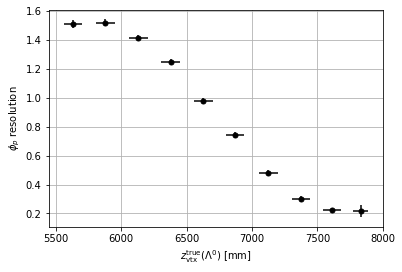

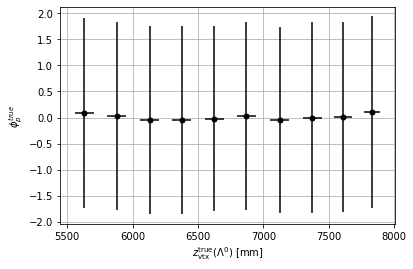

In [54]:
var_short_name = 'L_endvertex_z'
var_series = df_mc['MCTRUTH_L_ENDVERTEX_Z']
var_label = r'$z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]'
var_title = "$\Lambda^0$ $z$ vertex"
bin_left = 5500
bin_right = 8000
n_bins = 10

df_res = phi_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

phi_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

### Vs. $\Lambda^0$ decay vertex bias

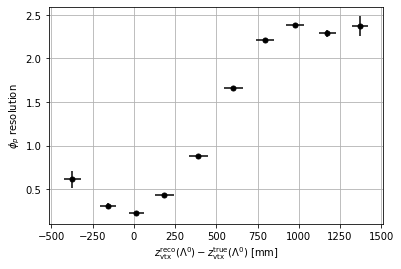

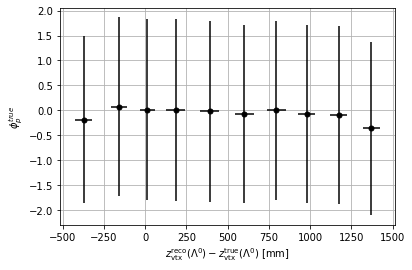

In [55]:
var_short_name = 'L_endvertex_z_bias'
var_series = df_mc['L_ENDVERTEX_Z'] - df_mc['MCTRUTH_L_ENDVERTEX_Z']
var_label = r'$z_\mathrm{vtx}^\mathrm{reco} (\Lambda^0) - z_\mathrm{vtx}^\mathrm{true} (\Lambda^0)$ [mm]'
var_title = "$\Lambda^0$ $z$ vertex bias"
bin_left = -500
bin_right = 1500
n_bins = 10

df_res = phi_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

phi_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

### Vs. proto-particle positions

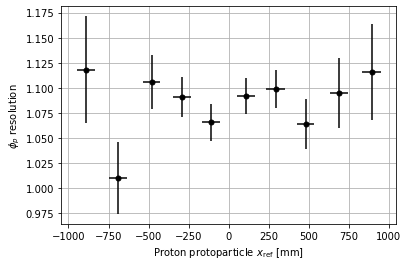

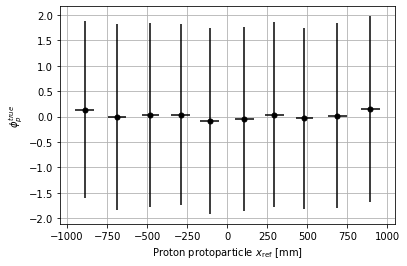

In [56]:
var_short_name = 'proton_PP_x'
var_series = df_mc['p_PP_X']
var_label = r'Proton protoparticle $x_\mathrm{ref}$ [mm]'
var_title = "proton proroparticle $x$ refpoint"
bin_left = -1000
bin_right = 1000
n_bins = 10

df_res = phi_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

phi_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)

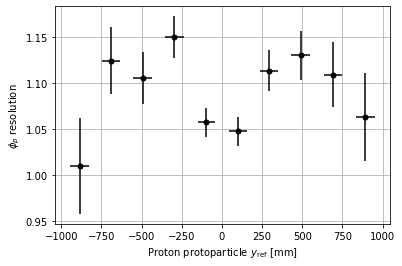

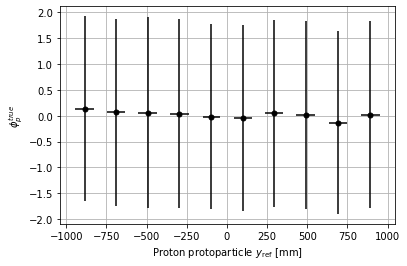

In [57]:
var_short_name = 'proton_PP_y'
var_series = df_mc['p_PP_Y']
var_label = r'Proton protoparticle $y_\mathrm{ref}$ [mm]'
var_title = "proton proroparticle $y$ refpoint"
bin_left = -1000
bin_right = 1000
n_bins = 10

df_res = phi_resolution_vs_variable_dataframe(
    df_mc,
    var_short_name,
    var_series,
    bin_left,
    bin_right,
    n_bins
)

phi_resolution_vs_variable_plots(
    df_res,
    var_short_name,
    var_label,
    var_title,
)